In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Reads zip file without writing to disk by emulating the file using a BytesIO buffer class
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip')
har_zip = ZipFile(BytesIO(resp.read()))
har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)
har_df = pd.concat([har_train_df, har_test_df])

har_ytr = pd.read_csv(har_zip.open('UCI HAR Dataset/train/y_train.txt'), delim_whitespace=True, header=None)
har_yte = pd.read_csv(har_zip.open('UCI HAR Dataset/test/y_test.txt'), delim_whitespace=True, header=None)
data1 = pd.concat([har_train_df,har_test_df],ignore_index=True)
data_y = pd.concat([har_ytr,har_yte],ignore_index=True)
data1 = pd.concat([data1,data_y],axis=1)

In [4]:
#data2 = data1.iloc[0:100,:]
features = data1.iloc[:, :-1].to_numpy()
qualities = data1.iloc[:, -1].to_numpy()

In [5]:
new_class = np.unique(qualities)
print(new_class)

[1 2 3 4 5 6]


In [6]:
covc = {}
meanc = {}
priorc = {}
lambda_var = 1
print(lambda_var)
for c in new_class:
    X_c = features[qualities == c]
    meanc[c] = np.mean(X_c, axis=0)
    covc[c] = np.cov(X_c, rowvar=False)
    covc[c] += lambda_var * np.eye(covc[c].shape[0])
    priorc[c] = len(X_c) / len(features)

print(covc)
#cov = cov

1
{1: array([[ 1.00244613e+00,  9.11530670e-06, -1.29152685e-04, ...,
        -5.27339859e-05, -2.28929354e-05, -1.16936019e-04],
       [ 9.11530670e-06,  1.00042223e+00,  9.18078107e-05, ...,
        -2.04621790e-05,  1.97661936e-05, -9.03647580e-05],
       [-1.29152685e-04,  9.18078107e-05,  1.00101085e+00, ...,
         2.74001744e-05,  5.12017661e-05,  6.70252537e-05],
       ...,
       [-5.27339859e-05, -2.04621790e-05,  2.74001744e-05, ...,
         1.00973600e+00,  4.24589363e-03,  6.17854887e-03],
       [-2.28929354e-05,  1.97661936e-05,  5.12017661e-05, ...,
         4.24589363e-03,  1.00436263e+00,  1.01160048e-03],
       [-1.16936019e-04, -9.03647580e-05,  6.70252537e-05, ...,
         6.17854887e-03,  1.01160048e-03,  1.01188808e+00]]), 2: array([[ 1.00576006e+00,  6.95849525e-04,  4.98064723e-04, ...,
         2.72798700e-05,  1.65681022e-04, -5.26365746e-04],
       [ 6.95849525e-04,  1.00137155e+00,  2.69124480e-04, ...,
         6.31727205e-04,  1.15227373e-04,  4.

In [18]:
def classify(x):
    posteriors = []
    for c in new_class:
        mean = meanc[c]
        cov = covc[c]
        prior = priorc[c]
        likelihood = multivariate_normal.pdf(x, mean=mean, cov=cov)
        posterior = likelihood * (prior)
        posteriors.append(posterior)
    return new_class[np.argmax(posteriors)]

y_pred = np.array([classify(x) for x in features])
error_prob = np.mean(y_pred != qualities)
print(f'Error Probability: {error_prob}')

Error Probability: 0.09699970870958345


In [19]:
print(y_pred.shape)

(10299,)


In [20]:
conf_matrix = confusion_matrix(qualities, y_pred)
#cm = conf_matrix[1:,:-1]
print(conf_matrix)

[[1668   51    3    0    0    0]
 [  37 1504    3    0    0    0]
 [ 150  196 1060    0    0    0]
 [   0    3    0 1292  475    7]
 [   0    0    0   72 1834    0]
 [   0    2    0    0    0 1942]]


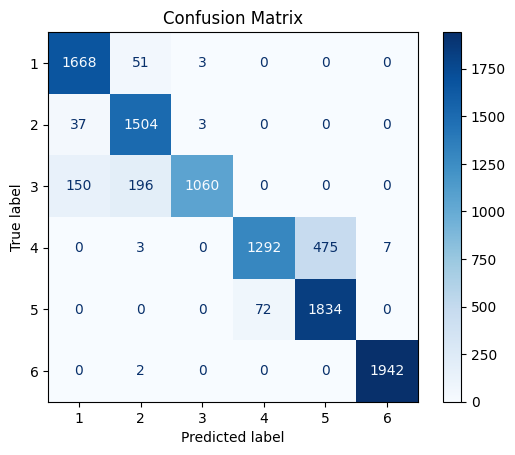

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(qualities, y_pred, display_labels=new_class, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [24]:
# # Display the confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(qualities, y_pred, display_labels=new_class, cmap=plt.cm.Blues)
# disp.ax_.set_title("Confusion Matrix")
# plt.show()

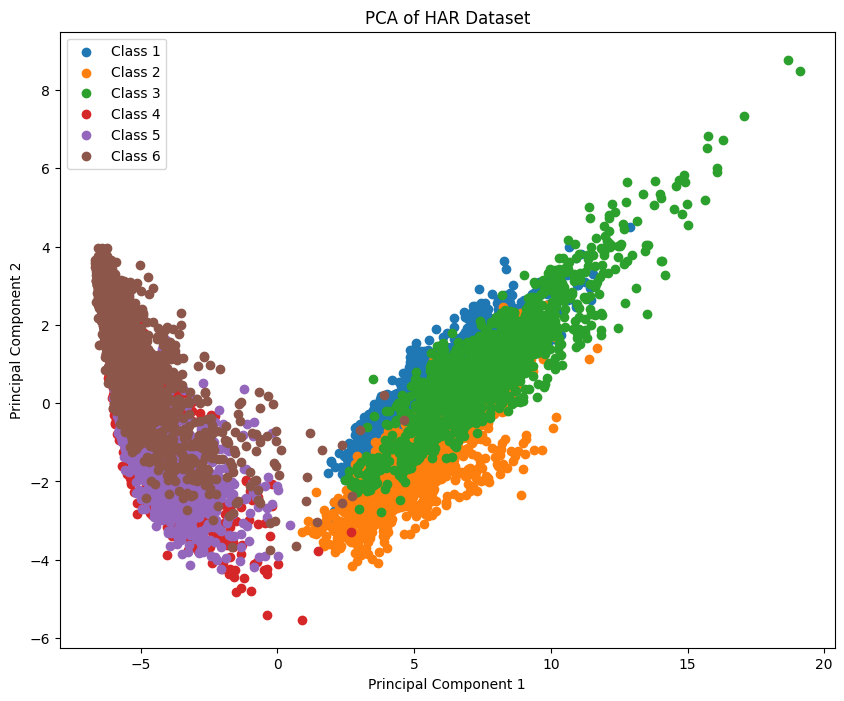

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
for c in new_class:
    plt.scatter(X_pca[qualities == c, 0], X_pca[qualities == c, 1], label=f'Class {c}')
plt.legend()
plt.title('PCA of HAR Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

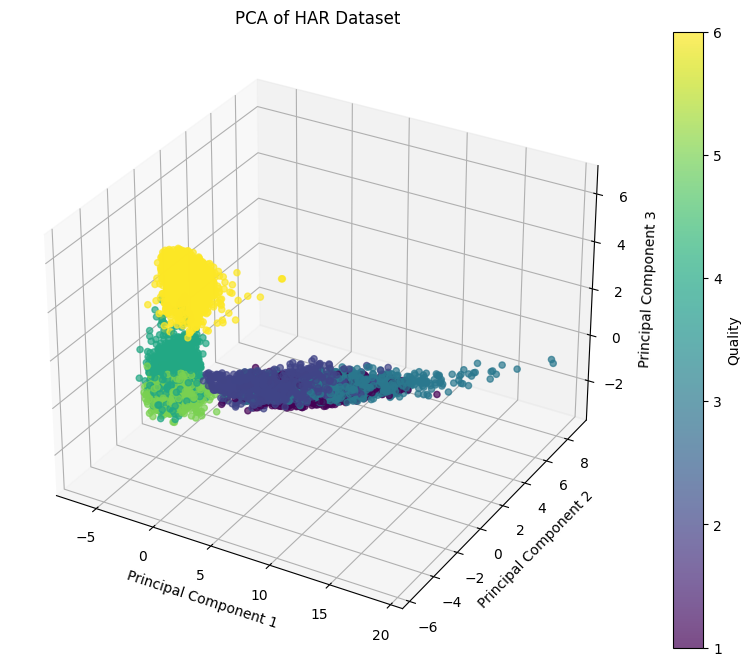

In [24]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(features)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=qualities, cmap='viridis', alpha=0.7)
ax.set_title('PCA of HAR Dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scat, ax=ax, label='Quality')
plt.show()

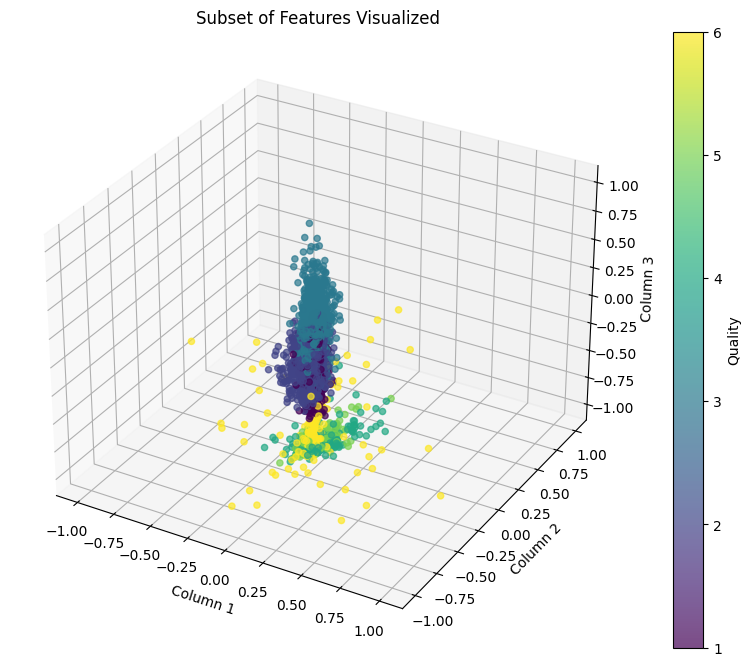

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(data1.iloc[:, 1].to_numpy(), data1.iloc[:, 2].to_numpy(), data1.iloc[:, 3].to_numpy(), c=qualities, cmap='viridis', alpha=0.7)
ax.set_title('Subset of Features Visualized')
ax.set_xlabel('Column 1')
ax.set_ylabel('Column 2')
ax.set_zlabel('Column 3')
fig.colorbar(scat, ax=ax, label='Quality')
plt.show()